# Symbolic FE (Gram) algorithm

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 64
eps = 1e-64

### Step 1: Obtain orthonormal bases of Gram polynomials on the boundaries

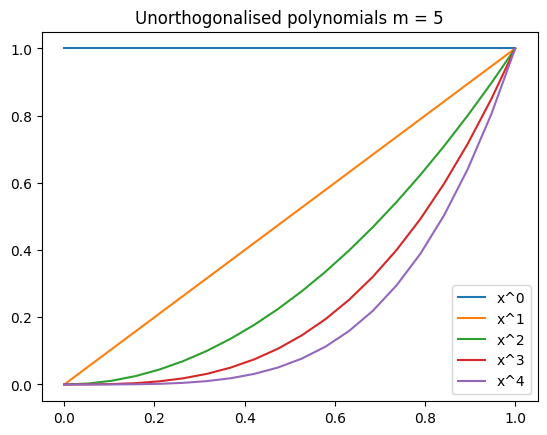

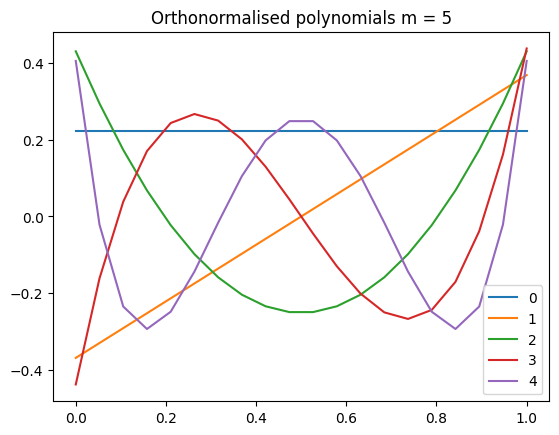

The orthonormalised polynomials and their scalar products
i = 0 u_ij = [1.0  4.511956179950586967241077346158633089232036476092292140267023716e-66  -1.141259504340442585831566622851889546099868049835109188420482469e-65  2.216166711916905951556646814142622723240441445610037610072332237e-65  3.425769081924247134097894461502503329368382989127132988264506389e-64]
i = 1 u_ij = [4.511956179950586967241077346158633089232036476092292140267023716e-66  1.0  3.01670638458352452878541753720813599776176982686462052898549971e-66  1.712277104464980918299274581296653937863600173558782573961026488e-64  -1.754018306001700806312000344305444906272334191179361128720095594e-63]
i = 2 u_ij = [-1.141259504340442585831566622851889546099868049835109188420482469e-65  3.01670638458352452878541753720813599776176982686462052898549971e-66  1.0  8.260150190789448641804720025257540865527932256333268835973543005e-65  -6.494458936703563207599967178117175913825940896195708484690180439e-64]
i = 3 u_ij = [2.216166711916905

In [2]:
class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

x = mp.linspace(0, 1, 20) 
gs = GramSchmidt(x, 5)
gs.debugInformation()

### Step 2: Function approximation via projection

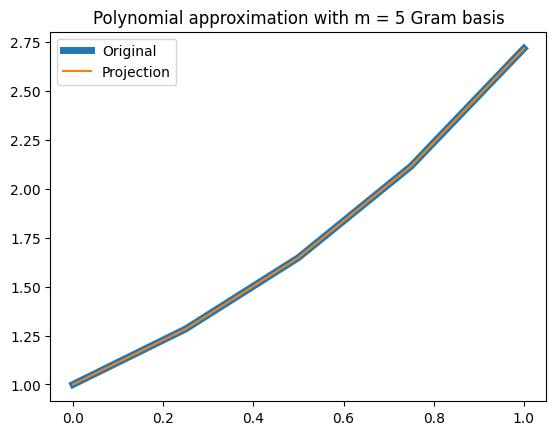

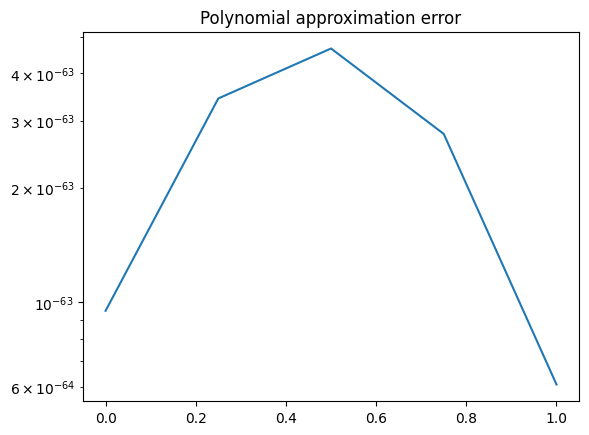

In [3]:
x = mp.linspace(0, 1, 5) 
f = mp.matrix(1, len(x))
for i in range(len(x)):
    f[i] = mp.exp(x[i])
    
m  = 5
gs = GramSchmidt( x, m = m )

coeffs = gs.projectFunction(f) 
frec   = gs.reconstructFunction(coeffs) 

plt.title(f"Polynomial approximation with m = {m} Gram basis")
plt.plot(x, f,    lw = 5,  label="Original")
plt.plot(x, frec,          label="Projection")
plt.legend()
plt.show()
plt.title(f"Polynomial approximation error")
plt.plot(x, np.abs(f - frec))
plt.yscale("log")
plt.show()

### Step 3: Compute FC(SVD) continuations for even and odd pairs of Gram polynomials

In [4]:
M_ALL_K  = 0 
M_EVEN_K = 1
M_ODD_K  = 2 


def t(g, mode = M_ALL_K):
    if g % 2 == 0:
        k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
    else:
        k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

    if mode == M_EVEN_K:
        k = k[k % 2 == 0]
    elif mode == M_ODD_K:
        k = k[k % 2 == 1]

    return k * mp.mpf(1)
    
def getX(Delta, Gamma):
    dxeval = Delta/(Gamma - 1) 
    xeval  = mp.matrix(1, Gamma) 
    for i in range(Gamma): 
        xeval[0, i] = 1 - Delta + i * dxeval
    return xeval

def getM(g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    x  = getX(Delta, Gamma) 
    M  = mp.matrix(Gamma, len(ks))
    for i in range(Gamma):
        for j, k in enumerate(ks):
            M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
    return M

def invertComplexM(M, cutoff):
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s) 
    r = M.cols
    if M.rows < M.cols:
        r = M.rows
    for i in range(r):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]

    Vht = Vh.transpose_conj()
    Ut  = U.transpose_conj()
    f1  = sinv * Ut
    f2  = Vht * f1 
    return  f2

def reconstruct(x, a, g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    rec = mp.matrix(1, len(x)) 
    for j, coeff in enumerate(a): 
        for i in range(len(x)): 
            rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
    return rec


def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 1000):
    a       = Minv * f.T
    r       = M * a - f.T
    counter = 0
    while mp.norm(r) > 2 * eps * mp.norm(a) and counter < maxiter: 
        delta    = Minv * r
        a        = a - delta 
        r        = M * a - f.T
        counter += 1
    return a

def computeExtension(x, g, Gamma, Delta, d, mode, f, threshold = 10, maxiter = 10):
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0) 
    a     = iterativeRefinement(M, Minv, f) 
    frec  = reconstruct(x, a, g, Gamma, Delta, d, mode)
    return frec


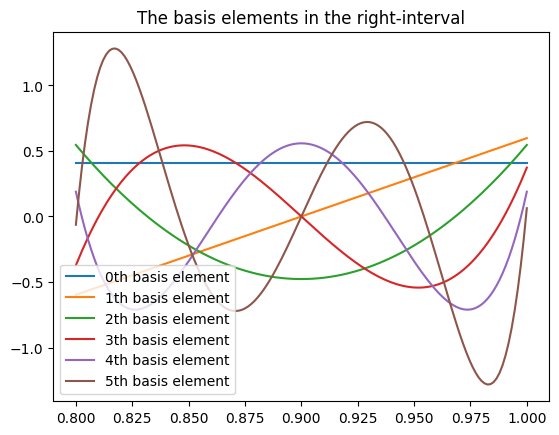

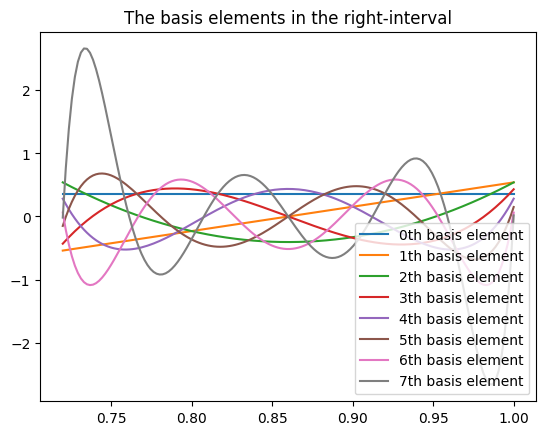

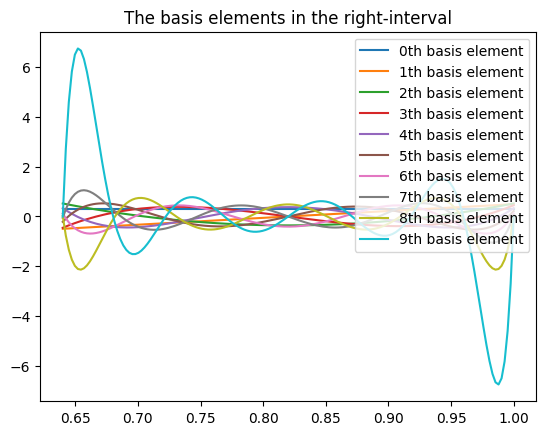

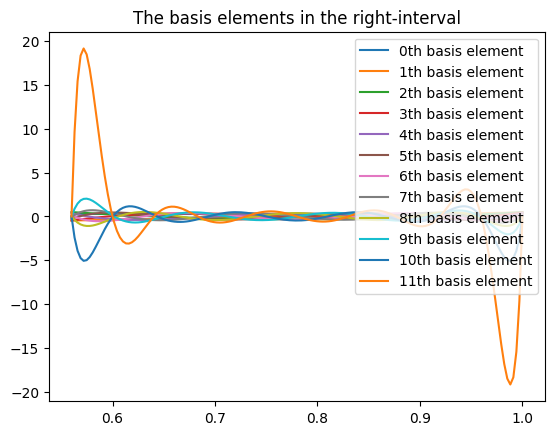

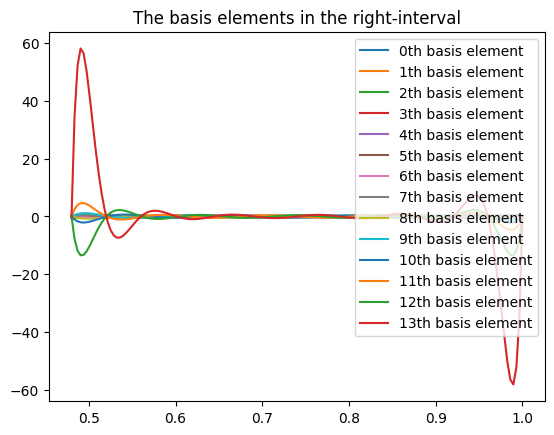

In [5]:
for m in [6, 8, 10, 12, 14]: 

    #### DEFAULT PARAMS
    # m      = 10
    # n      = 10 
    # nDelta = 10 
    # nd     = 27
    # Gamma  = 150
    # g      = 63
    ####################
    m      = m
    nDelta = m
    nd     = 26
    Gamma  = 150
    g      = 63

    h      = 1/(nd - 1) 
    d      = (nd - 1) * h 
    Delta  = (nDelta  - 1) * h 

    x = mp.linspace(0, 1, nd)

    leftBoundary  = x[       :nDelta]
    rightBoundary = x[-nDelta:      ]

    lgs = GramSchmidt(leftBoundary, m)
    rgs = GramSchmidt(rightBoundary, m)

    dxeval = Delta/(Gamma - 1) 
    xeval  = mp.matrix(1, Gamma) 
    for i in range(Gamma): 
        xeval[0, i] = 1 - Delta + i * dxeval

    plt.title("The basis elements in the right-interval")
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        plt.plot(xeval, yeval, label=f"{i}th basis element") 
    plt.legend()
    plt.show()

    xext  = mp.linspace(1 - Delta, 1 + Delta + 2*d, 1000) 
    mode = M_EVEN_K
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0)
    evencoeffs = []
    evenbasis = []
    evenfrecs = []
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        a     = iterativeRefinement(M, Minv, yeval) 
        frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
        evencoeffs.append(a) 
        evenbasis.append(yeval)
        evenfrecs.append(frec)


    mode = M_ODD_K
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0)
    oddcoeffs = []
    oddbasis = []
    oddfrecs = []
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        a     = iterativeRefinement(M, Minv, yeval) 
        frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
        oddcoeffs.append(a) 
        oddbasis.append(yeval)
        oddfrecs.append(frec)

    r = m
    Next = 2 * nd + 2 * nDelta - 4
    xstore = mp.matrix(1, Next)
    for i in range(Next): 
        xstore[i] = 1 - Delta + i * h

    F = mp.matrix(2 * r, Next)

    mode = M_EVEN_K

    for i in range(r): 
        F[i, :] = reconstruct(xstore, evencoeffs[i], g, Gamma, Delta, d, mode)

    mode = M_ODD_K
    for i in range(r): 
        F[i+m, :] = reconstruct(xstore, oddcoeffs[i], g, Gamma, Delta, d, mode)

    Pr = mp.matrix(m, nDelta)
    Pl = mp.matrix(m, nDelta)
    for i in range(r): 
        Pr[i, :] = rgs.evaluateBasis(rightBoundary, i)
        Pl[i, :] = lgs.evaluateBasis(leftBoundary, i)

    reF = np.array(F.apply(mp.re), dtype=float).reshape(2 * r, Next)
    reF.tofile(f"nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
    rePr = np.array(Pr, dtype=float).reshape(r, nDelta) 
    rePr.tofile(f"Pright_nD={nDelta}.bin")
    rePl = np.array(Pl, dtype=float).reshape(r, nDelta) 
    rePl.tofile(f"Pleft_nD={nDelta}.bin")        
    Fe = reF[:nDelta, :]
    Fo = reF[nDelta:, :]


## Compute Table 5.2

In [ ]:
xtest  = mp.linspace(1 - Delta, 1, 900) 
r = m 
mode = M_EVEN_K
evenerrors = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xtest, i)
    frec  = reconstruct(xtest, evencoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    evenerrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(f"Even error {np.float(evenerrors[-1]):1.1e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

mode = M_ODD_K
odderrors = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xtest, i)
    frec  = reconstruct(xtest, oddcoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    odderrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(f"Odd error {np.float(odderrors[-1]):1.1e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

Maximum errors (evaluated as maxima over 900 points in the set [1-Delta, 1]) that result from the even and odd continuations of the Gram Polynomials for the parameter values n_Delta = 10, d/Delta = 26/9, g = 63, Gamma = 150. 

In [30]:
for i in range(r): 
    print(f"f{i}_even: {evenerrors[i]} f{i}_odd: {odderrors[i]}")

f0_even: 1.424335161863969812120986340434293573133144875043580531637618117e-65 f0_odd: 1.822021902591742612449634826126081473818763224906558805237593663e-25
f1_even: 6.683989984108406681662114867858556189115830596035913619314122771e-24 f1_odd: 4.666276857735980746427709696102053102398735749072366375351204351e-27
f2_even: 4.019514051604980898019380489251735444867791981572113670074050731e-25 f2_odd: 9.848349081680130215072815080626397775057144031641411955978481811e-24
f3_even: 4.217462672820610668186143079554521234407407371898587536111929962e-22 f3_odd: 9.300694082636696064985941914866974663581547818066858033890566165e-25
f4_even: 5.880800748809751833588122352653880019910007191879030349473689826e-23 f4_odd: 6.983754705271000218183799758450298973568402546313128691980583857e-22
f5_even: 0.00000000000000000003488213187117751253877522012967219251021801125875526108642348236 f5_odd: 1.324297036082298734703091218406771653799790058901302850643760371e-22
f6_even: 9.6332043989405632105489219951236

## Finally store extensions as well as values of Gram basis

In [287]:
1 - Delta + (2 * nd + 2 * nDelta - 4) * h, 1 - Delta + 2 * Delta + 2*d

(3.3600000000000003, 3.36)

Store everything in double precision in binary files

In [ ]:
def printCMatrix(mat, name):
    n, m = mat.shape
    print(f"const real {name}[{n}][{m}] = ", end="")
    print("{")
    for i in range(n):
        print("{", end="")
        for j in range(m):
            print(f"{mat[i,j]:10.64f}", end="")
            if j != m - 1:
                print(", ", end="")
        

        print("}", end=",\n")  
    print("}", end="")  

printCMatrix(Fe, "Fe")
print("")
printCMatrix(Fo, "Fo")
print("")
printCMatrix(rePl, "Pl")
print("")
printCMatrix(rePr, "Pr")

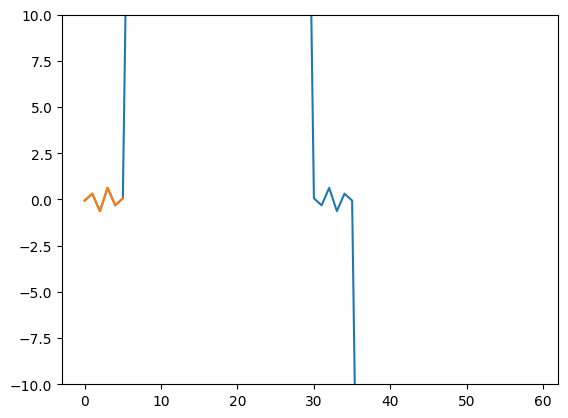

In [46]:
i = 5
plt.ylim(-10, 10)
plt.plot(reF[i + r, :])
plt.plot(rePr[i, :])